In [5]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_sbi

In [6]:
%presentation_style

In [7]:
%%capture

%set_random_seed 12

In [8]:
%load_latex_macros


$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\newcommand{\amax}{{\text{argmax}}}$
$\newcommand{\P}{{\mathbb{P}}}$
$\newcommand{\E}{{\mathbb{E}}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\Z}{{\mathbb{Z}}}$
$\newcommand{\N}{{\mathbb{N}}}$
$\newcommand{\C}{{\mathbb{C}}}$
$\newcommand{\abs}[1]{{ \left| #1 \right| }}$
$\newcommand{\simpl}[1]{{\Delta^{#1} }}$


<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Neural Density Estimation</div>

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import sbi.analysis
import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from tqdm.notebook import trange, tqdm

from tfl_training_sbi import mdn
from tfl_training_sbi.config import (
    default_remote_storage,
    get_config,
    root_dir,
)
from tfl_training_sbi.data_utils import (
    SIRSimulation,
    SIRStdScaler,
    load_sir_data,
)
from tfl_training_sbi.utils_sir import eval_sir_model

storage = default_remote_storage()
c = get_config(reload=True)


# Introduction to Neural Density Estimation for SBI

- We've seen Likelihood-free inference with ABC
- We've seen Conditional Density Estimation

Now, we'll combine the idea of Likelihood-free inference with Density Estimation, i.e. Simulation-based inference (SBI)

<figure>
    <center>
    <img src="_static/images/sbi_concept_figure.png" style="width:50%"/>
    <figcaption>Fig. 1 - Schematic overview of SBI. Figure taken from Jan Boelts, 2023</figcaption>
</figure>


## Neural Density Estimation for SBI

Parameterization vs. Learning of a distribution.

Methodologies: 

- Neural Posterior Estimation (NPE) $\leftarrow$ **This notebook**
- Neural Likelihood Estimation (NLE)
- Neural Ratio Estimation (NRE)
- Neural Score Estimation (NSE)
- ...
- And even sequential variants!


## Idea of Neural Posterior Estimation

- Learn the posterior $p(\theta|x)$ of a parameter $\theta$ given data $x$ using Conditional Density Estimation
- Learn an estimator for $p(\theta|x)$ on data from the joint distribution $p(\theta, x)$
$$
p(\theta \mid x) \propto p(x \mid \theta) p(\theta) = p(\theta, x)
$$

## Sampling from the Joint Distribution

 1. Define a prior $p(\theta)$
 2. Define a simulator / generator $g(\theta)$
 3. Draw sample $\theta \sim p(\theta)$ and obtain $x = g(\theta)$, where $x\sim p(x\mid\theta)$

$$
p(\theta, x) = p(\theta) p(x \mid \theta)
$$

## Posterior decomposition

<figure>
    <center>
    <img src="_static/images/illustration_posterior.png" style="width:50%"/>
    <figcaption>Fig. 2 - Figure taken from <a href="https://mlcolab.org/simulation-based-inference-for-scientific-discovery">MLColab</a></figcaption>
</figure>

## Example: Neural Posterior Estimation

We will learn the parameterization of Gaussian mixture model using a neural
network.

Parameters will be adapted using the maximum likelihood principle: minimizing
the negative log-likelihood of the data under the model.

We will use a Mixture Density Network (MDN) to do so, as seen before. 

Note: there are more powerful neural density estimators, e.g. Normalizing Flows, or Diffusion Models.

<figure>
    <center>
    <img src="_static/images/illustration_npe_mdn.png" style="width:50%"/>
    <figcaption>Fig. 3 - Figure taken from <a href="https://mlcolab.org/simulation-based-inference-for-scientific-discovery">MLColab</a></figcaption>
</figure>


### Example Data: SIR Dataset

For this example, the SIR dataset is used. 

**Task:** Load the data and get familiar with it. Again, a pseudo simulator is
provided. 

In [10]:
# we provide a pre-computed dataset according to the differential equations
# defining the SIR model.
# the pseudo simulator draws samples at random
sir_theta, sir_x = load_sir_data(c.data)
# load class for z-scoring SIR data.
sir_scaler = SIRStdScaler()
simulator = SIRSimulation(
    sir_theta[:-1], sir_x[:-1], transformations=Compose([sir_scaler])
)


In [11]:
# let's fix the last pair as observation
theta_o_raw, x_o_raw = torch.tensor(sir_theta[-1:]), torch.tensor(sir_x[-1:])
# z-scoring
scaled_data = sir_scaler({"theta": theta_o_raw, "obs": x_o_raw})
theta_o, x_o = scaled_data["theta"], scaled_data["obs"]


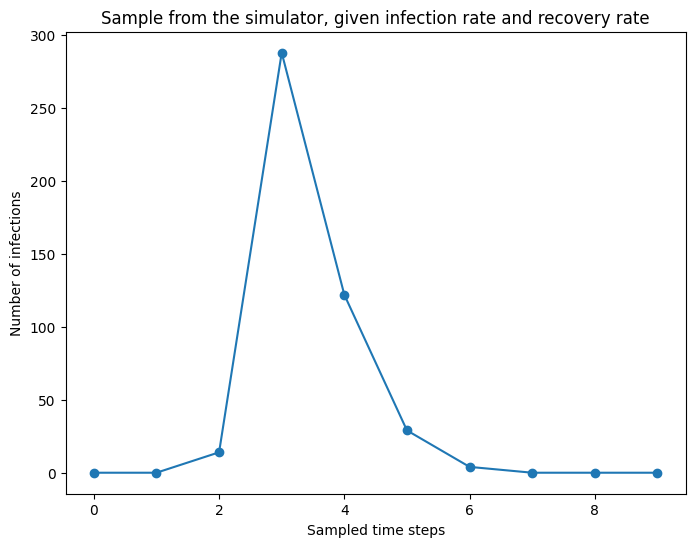

In [12]:
# familiarize yourself with the data; feel free to call this cell several times
# as the observation is randomly sampled
plt.figure(figsize=(8, 6))
plt.plot(simulator()[1][:].T, "o-", alpha=1.0)
plt.title("Sample from the simulator, given infection rate and recovery rate")
plt.ylabel("Number of infections")
plt.xlabel("Sampled time steps")
plt.show()


**Task:** Define a `torch DataLoader` object which uses the above defined dataset with a suitable batch size. Feel free to experiment with `shuffle` and `drop_last` options. Why and how would you use them?

In [13]:
# define a torch DatLoader
# preprocessing of data, e.g. standardization happens in the Dataset, i.e. simulator
sir_dataloader = DataLoader(simulator, batch_size=1024, shuffle=True, drop_last=True)


**Task:** We're using a Gaussian mixture model to approximate the posterior. The here used `MDN` module allows to provide a `hidden_net` for feature extraction. Define a fully connected feature extractor and initialize a Mixture Density Network as density estimator. Feel free to use the below structure.

Furthermore, think about the following parameters. What did you choose?

- `features`: number of variable in the problem
- `num_components`: number of Gaussians in the mixture 
- `hidden_features`: output dim. of the linear layer from the feature extractor 


```python
<YOUR-FEAT-EXTRACTOR> = nn.Sequential(
    ...,
)

mixture_density_net = mdn.MultivariateGaussianMDN(
    features=<TODO>,
    hidden_net=<YOUR-FEAT-EXTRACTOR>,
    num_components=<TODO>,
    hidden_features=<TODO>,
)

```

In [14]:
# initialize the mixture density network, parameterizing a
# `num_components`-component mixture of Gaussians with `features`
# features, i.e. variables
mixture_density_net = mdn.MultivariateGaussianMDN(
    features=2,
    hidden_net=nn.Sequential(
        nn.Linear(10, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
    ),
    num_components=4,
    hidden_features=16,
)


In [21]:
loss_hist = []
num_epochs = 20

# fit MDN using negative log-likelihood loss
opt = torch.optim.Adam(mixture_density_net.parameters(), lr=0.001)
for e in trange(num_epochs):
    for batch in sir_dataloader:
        theta_batch, x_batch = batch["theta"], batch["obs"]

        opt.zero_grad()

        # get the mixture components
        (
            weights_of_each_gaussian,
            means,
            variances,
        ) = mixture_density_net.get_mixture_components(x_batch)

        # compute Likelihood of sample under current parameterization
        log_probs = mdn.mog_log_prob(
            theta_batch, weights_of_each_gaussian, means, variances
        )

        # compute the negative log-likelihood loss
        loss = -log_probs.sum()
        loss.backward()

        # track  the loss per batch
        loss_hist.append(loss.item())

        # update the parameters using gradient descent
        opt.step()


  0%|          | 0/20 [00:00<?, ?it/s]

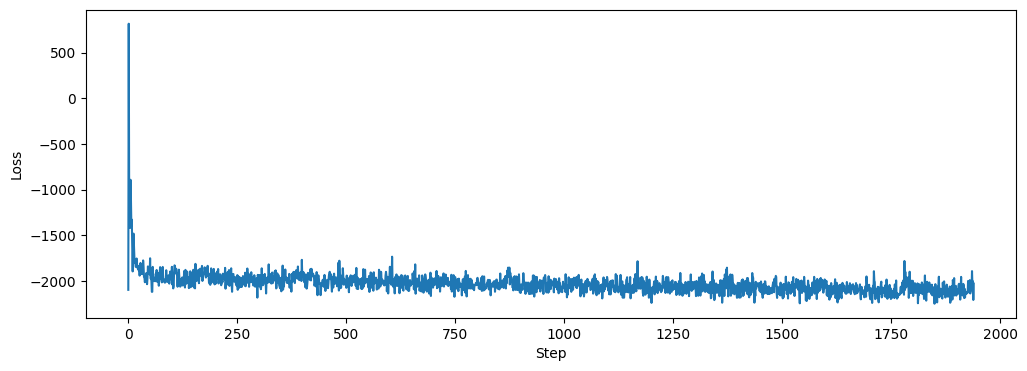

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(loss_hist)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()


### Inspecting the Approximated Posterior Distribution

We have trained a MDN to approximate the posterior distribution over SIR parameters, $\hat{p}(\theta \mid
x_o)$. 

Below, we will inspect the learned posterior distribution by

1. Drawing samples and visualizing the two-dimensional posterior distribution
2. Simulating data with samples from the posterior and compare to the original observation $x_o$.


**Task:** Use the trained posterior approximator to sample from the conditional distribution, given the test observation. 

Therefore, obtain the parameters for the Gaussian mixture using the `.get_mixture_components(..)` method of the density estimator object. Then, use the `mog_sample(..)` function of the `mdn` module.

In order to stick with following cells, please store the obtained samples in a tensor called `samples`.

In [23]:
num_samples = 50_000
samples = []

# get the posterior, i.e. get the mixture components
weights, means, variances = mixture_density_net.get_mixture_components(x_o)

for _ in trange(num_samples):
    # sample form mixture of Gaussians
    sample = mdn.mog_sample(weights, means, variances)
    samples.append(sample)

samples = torch.cat(samples).detach()

  0%|          | 0/50000 [00:00<?, ?it/s]

#### Great, you've run through your first SBI workflow! 🎉

In [24]:
# rescale to original parameter ranges.
samples_unscaled = sir_scaler.rescale(
    {"theta": samples, "obs": torch.ones_like(samples)}
)["theta"]

# eval. the SIR model for a selected number of samples
sample_obs = []
for i in trange(1_000):
    samples_obs = eval_sir_model(theta=samples_unscaled[i], population_size=1_000_000)
    sample_obs.append(samples_obs)

# stack the collected samples into a big array of shape (N, 160, 3)
sample_obs = np.stack(sample_obs, axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Inspect Resulting Posterior Approximation

Plot the marginal distributions per parameter and the joint distribution of the
parameters.


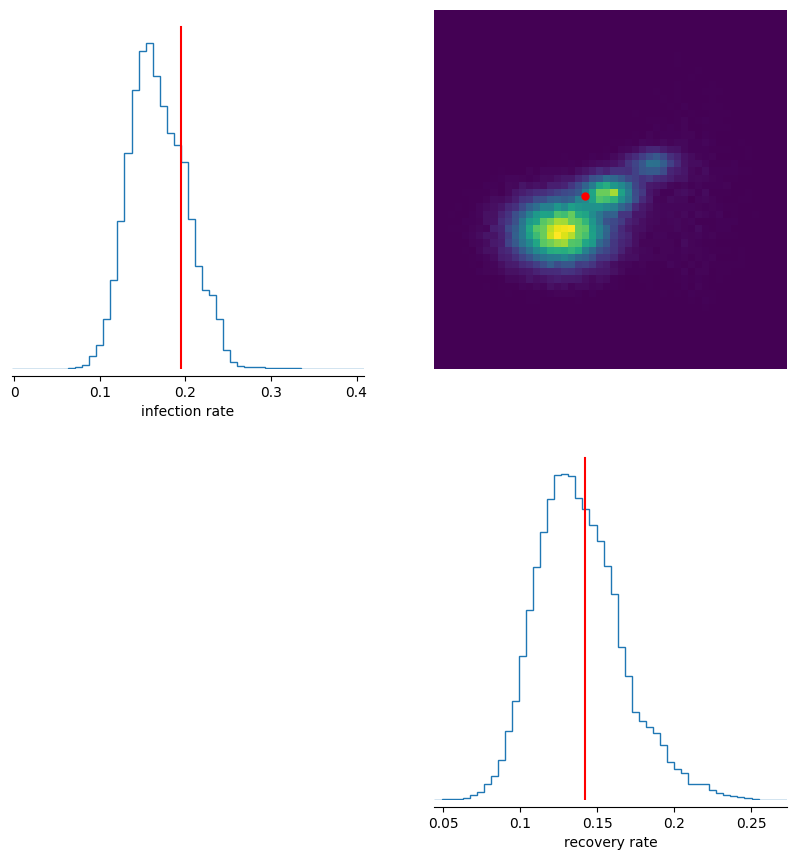

In [25]:
_ = sbi.analysis.pairplot(
    samples_unscaled, points=theta_o_raw, points_offdiag={"markersize": 10}, points_colors="r", 
    labels=["infection rate", "recovery rate"],
)

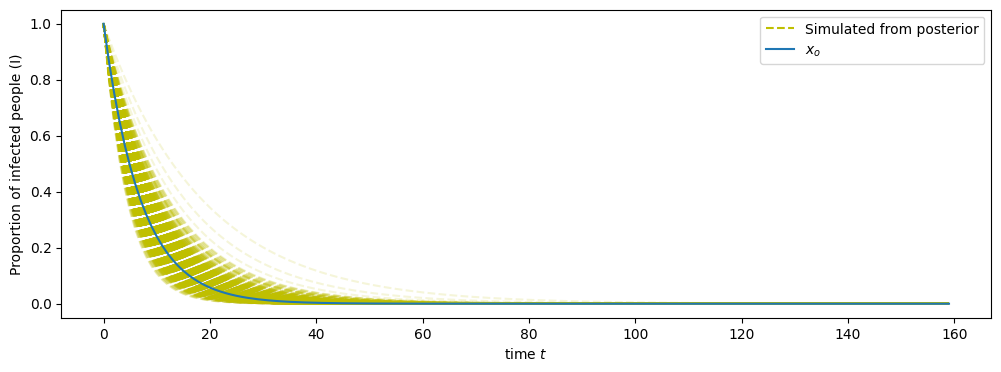

In [41]:
# eval the SIR model for the true parameters to get a full scale observation
obs_x_full_scale = eval_sir_model(theta=theta_o_raw.numpy()[0], population_size=1_000_000)

plt.figure(figsize=(12, 4))
plt.plot(sample_obs[:, :, 1].T, "y--", alpha=.15)
plt.plot([], [], "y--", label="Simulated from posterior")
plt.plot(obs_x_full_scale[:, 1], "-", alpha=1.0, label="$x_o$")

plt.xlabel("time $t$")
plt.ylabel("Proportion of infected people (I)")
plt.legend()

plt.show()

## Treatment of Time Series Data

- Subsampling 
- Summary Statistics
- Feature Extraction via different models 

<figure>
    <center>
    <img src="_static/images/illustration_mdn_feat_extraction.png" style="width:50%"/>
    <figcaption>Fig. 4 - Pre-pending a powerful feature extractor might be necessary in order to obtain meaningful features from time series data. Figure taken from <a href="https://mlcolab.org/simulation-based-inference-for-scientific-discovery">MLColab</a></figcaption>
</figure>

## Sequential Neural * Estimation 

- Sample inefficiency is a problem of SBI, esp. for costly simulators
- Many samples from the prior yield observations with low likelihood
- **Idea:** re-condition the prior sequentially on the observed data to narrow
  the "search space" --> Sequential Estimation

## Example: Sequential Posterior Estimation (SNPE)

1. Train a neural density estimator $\hat{p}_{\phi}^{(i)}(\theta \mid
   \mathbf{x})$ based on $\theta \sim p^{(i-1)}(\theta)$
2. Substitute the prior $p^{(i-1)}(\theta)$ by $\hat{p}_{\phi}^{(i)}(\theta)$
3. Train $\hat{p}_{\phi}^{(i+1)}(\theta \mid \mathbf{x})$ based on $\hat{p}_{\phi}^{(i)}(\theta)$
4. Iterate until convergence

<figure>
    <center>
    <img src="_static/images/illustration_snpe.png" style="width:25%"/>
    <figcaption>Fig. 5 - Illustrating the iterative refinement of the posterior approximation with multi-round inference. Figure obtained JM Lueckmann.</figcaption>
</figure>

## The Problem with SN*E

 - We want to obtain $\hat{p}(\theta \mid \mathbf{x}) \approx p(\theta \mid \mathbf{x})$.
 - But when altering the prior, we also alter the posterior.
    $$
        \bar{\hat{p}}(\theta \mid \mathbf{x}) \approx p(\mathbf{x} \mid \theta) \bar{p}(\theta)
    $$
 - The divergence of the posterior has to be corrected

## Popular Methods for SNPE

All methods introduce a different method to correct the posterior approximation. 

- SNPE-A (Papamakarios, Murray, 2016, _"Fast $\epsilon$-free Bayesian inference..."_)
- SNPE-B (Lueckmann, Goncalves, et al. 2017, _"Flexible statistical inference..."_)
- SNPE-C (APT) (Greenberg, Nonnenmacher, Macke, 2019, _"Automatic posterior transformation..."_)

**Note**: Without the sequential approach, all methods are the same and train by
maximizing the log-Likelihood.

## Summary

#### Neural Posterior Estimation works by

  1. Sampling from the prior $\theta \sim p(\theta)$
  2. Drawing samples from the joint by forward propagation $\mathbf{x} \sim p(\mathbf{x}|\theta)$
  3. Train a conditional density estimator $\hat{p}_{\phi}(\theta|\mathbf{x})$
on the samples $\{ (\theta, \mathbf{x}) \}^N_{i=1}$
  4. Evaluate the conditional density estimator at certain observations $\mathbf{x}_o$

#### Benefits 

 - NPE is **amortized** s.t. no re-training is required for new observations;
   contrary to ABC
 - (Embedding) Networks allow to cope with high-dimensional data

#### Sequential NPE

 - Enhances **sample efficiency**
 - Requires adaptations to correct the diverging posterior

<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Thank you for the attention!</div>